In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose

In [2]:
def get_noisy_data(array, factor: float):
    return tf.clip_by_value(array + factor * np.random.normal(size=array.shape), clip_value_min=0, clip_value_max=1).numpy()


def plot_results(model, test_set_x, noise_factor = 0.4, n_imgs = 10, n_iters=1):
    _set = get_noisy_data(test_set_x[:n_imgs], noise_factor)
    predicted = model.predict(_set)
    for _ in range(n_iters - 1):
        predicted = model.predict(predicted)
    
    plt.figure(figsize=(20, 8))
    for i in range(n_imgs):
        ax = plt.subplot(4, n_imgs, i + 1)
        plt.imshow(_set[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, n_imgs, i + 1 + n_imgs)
        plt.imshow(predicted[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, n_imgs, i + 1 + 2 * n_imgs)
        plt.imshow(model.predict(test_set_x[i].reshape(1, 28, 28, 1)).reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, n_imgs, i + 1 + 3 * n_imgs)
        plt.imshow(test_set_x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show() 


def test_accuracy(model_classifier, model_autoencoder, test_set_x, test_set_y, noise_factor = 0.4, n_iter = 5):
    noisy_test_set = get_noisy_data(test_set_x, noise_factor)
    labels = model_classifier.predict(test_set_x)
    labels = np.argmax(labels, axis=1)
    acc = (np.where(labels == test_set_y, 1, 0)).mean()
    print('Accuracy of the model (without noise):', acc)

    labels = model_classifier.predict(noisy_test_set)
    labels = np.argmax(labels, axis=1)
    acc = (np.where(labels == test_set_y, 1, 0)).mean()
    print('Accuracy of the model (with noise):', acc)

    results = noisy_test_set[:]
    for i in range(n_iter):
        results = model_autoencoder.predict(results)
        labels = model_classifier.predict(results)
        labels = np.argmax(labels, axis=1)
        acc = (np.where(labels == test_set_y, 1, 0)).mean()
        print(f'Accuracy of the model after {i + 1}-iteration', acc)


def test_noise_acc_cl(model_classifier, test_set_x, test_set_y, n_steps = 20):
    labels = model_classifier.predict(test_set_x)
    labels = np.argmax(labels, axis=1)
    acc = (np.where(labels == test_set_y, 1, 0)).mean()
    print('Accuracy of the model (without noise):', acc)

    for j in range(n_steps + 1):
        noise_factor = 0.1 + j * (0.8 / n_steps)
        noisy_test_set = get_noisy_data(test_set_x, noise_factor)
        labels = model_classifier.predict(noisy_test_set)
        labels = np.argmax(labels, axis=1)
        acc_old = (np.where(labels == test_set_y, 1, 0)).mean()

        print(f'Accuracy of the model (with noise factor = {noise_factor}): {acc_old}')


def test_noise_acc(model_classifier, model_autoencoder, test_set_x, test_set_y, n_iter = 1, n_steps = 20):
    labels = model_classifier.predict(test_set_x)
    labels = np.argmax(labels, axis=1)
    acc = (np.where(labels == test_set_y, 1, 0)).mean()
    print('Accuracy of the model (without noise):', acc)

    for j in range(n_steps + 1):
        noise_factor = 0.1 + j * (0.8 / n_steps)
        noisy_test_set = get_noisy_data(test_set_x, noise_factor)
        labels = model_classifier.predict(noisy_test_set)
        labels = np.argmax(labels, axis=1)
        acc_old = (np.where(labels == test_set_y, 1, 0)).mean()

        results = noisy_test_set[:]
        for i in range(n_iter):
            results = model_autoencoder.predict(results)
        labels = model_classifier.predict(results)
        labels = np.argmax(labels, axis=1)
        acc = (np.where(labels == test_set_y, 1, 0)).mean()
        print(f'Accuracy of the model (with noise factor = {noise_factor}): {acc_old},  after using autoencoder: {acc}, diff = {acc - acc_old}, diff(%): {(acc - acc_old) / acc_old * 100}')


def test_model_autoencoder(model_classifier, model_autoencoder, test_set_x, test_set_y, noise_factor = 0.5, n_iter_noise = 1):
    print(f'First line - noisy images made from test data (noise factor = {noise_factor})\nSecond line - encoded images made from noisy data\nThird line - encoded images made from test data\nFourth line - test data')
    plot_results(model_autoencoder, test_set_x, noise_factor = noise_factor)
    print('')
    test_accuracy(model_classifier, model_autoencoder, test_set_x, test_set_y, noise_factor = noise_factor, n_iter = 5)
    print('')
    test_noise_acc(model_classifier, model_autoencoder, test_set_x, test_set_y, n_iter = n_iter_noise, n_steps = 8)


def plot_one_img(id, model, test_set_x, noise_factor = 0.5):
    img = test_set_x[id].reshape(1, 28, 28, 1)
    noisy_img = get_noisy_data(img, noise_factor)
    output_img = model.predict(noisy_img)

    ax = plt.subplot(1, 3, 1)
    plt.imshow(img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(1, 3, 2)
    plt.imshow(noisy_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(1, 3, 3)
    plt.imshow(output_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
# simple data preparations
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [5]:
# model that will show how accurate autoencoders are
model_classifier = tf.keras.Sequential([
                                        Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
                                        MaxPooling2D(2, 2),
                                        Conv2D(64, 3, activation='relu'),
                                        MaxPooling2D(2, 2),
                                        Flatten(),
                                        Dense(128, activation='relu'),
                                        Dense(10, activation='softmax')
])
model_classifier.summary()

model_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# model_classifier.fit(x_train, y_train, epochs=2, validation_data=(x_test, y_test))

model_classifier = tf.keras.models.load_model('models/model_classifier.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [6]:
model_linear = tf.keras.Sequential([
                                    Flatten(input_shape=(28, 28, 1)),
                                    Dense(128, activation='relu'),
                                    Dense(28 * 28, activation='sigmoid'),
                                    Reshape((28, 28, 1))
])
model_linear.summary()

model_linear.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

# model_linear.fit(x_train, x_train, epochs=15, validation_data=(x_test, x_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_dcnn_large = tf.keras.Sequential([
                                        Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
                                        MaxPooling2D(2, 2),
                                        Conv2D(64, 3, padding='same', activation='relu'),
                                        MaxPooling2D(2, 2),
                                        Conv2D(128, 3, padding='same', activation='relu'),
                                        Conv2DTranspose(64, 3, padding='same', activation='relu'),
                                        UpSampling2D((2, 2)),
                                        Conv2DTranspose(32, 3, padding='same', activation='relu'),
                                        UpSampling2D((2, 2)),
                                        Conv2D(1, 3, padding='same', activation='sigmoid')
])
model_dcnn_large.summary()

model_dcnn_large.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

# model_dcnn_large.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          73792     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)       

In [8]:
model_dcnn_medium = tf.keras.Sequential([
                                         Conv2D(16, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
                                         MaxPooling2D(2, 2),
                                         Conv2D(32, 3, padding='same', activation='relu'),
                                         MaxPooling2D(2, 2),
                                         Conv2D(64, 3, padding='same', activation='relu'),
                                         Conv2DTranspose(32, 3, padding='same', activation='relu'),
                                         UpSampling2D((2, 2)),
                                         Conv2DTranspose(16, 3, padding='same', activation='relu'),
                                         UpSampling2D((2, 2)),
                                         Conv2D(1, 3, padding='same', activation='sigmoid')
])
model_dcnn_medium.summary()

model_dcnn_medium.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['mse'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 7, 7, 32)          18464     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 32)       

In [9]:
# model_dcnn_medium.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))
model_dcnn_medium = tf.keras.models.load_model('models/model_dcnn_medium.h5')

In [10]:
model_dcnn_small = tf.keras.Sequential([
                                        Conv2D(8, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
                                        MaxPooling2D(2, 2),
                                        Conv2D(16, 3, padding='same', activation='relu'),
                                        MaxPooling2D(2, 2),
                                        Conv2D(32, 3, padding='same', activation='relu'),
                                        Conv2DTranspose(16, 3, padding='same', activation='relu'),
                                        UpSampling2D((2, 2)),
                                        Conv2DTranspose(8, 3, padding='same', activation='relu'),
                                        UpSampling2D((2, 2)),
                                        Conv2D(1, 3, padding='same', activation='sigmoid')
])
model_dcnn_small.summary()

model_dcnn_small.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

# model_dcnn_small.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 16)          4624      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 16)       

In [11]:
model_cnn_plus_dense = tf.keras.Sequential([
                                            Conv2D(16, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
                                            MaxPooling2D(2, 2),
                                            Conv2D(32, 3, padding='same', activation='relu'),
                                            MaxPooling2D(2, 2),
                                            Flatten(),
                                            Dense(128, activation='relu'),
                                            Dense(7 * 7 * 32, activation='relu'),
                                            Reshape((7, 7, 32)),
                                            UpSampling2D((2, 2)),
                                            Conv2DTranspose(16, 3, padding='same', activation='relu'),
                                            UpSampling2D((2, 2)),
                                            Conv2D(1, 3, padding='same', activation='sigmoid')
])
model_cnn_plus_dense.summary()

model_cnn_plus_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

# model_cnn_plus_dense.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_5 (Dense)              (None, 1568)             

In [12]:
n_filters = 16
inp = tf.keras.Input(shape=(28, 28, 1))

conv_1 = Conv2D(n_filters, 3, activation='relu', padding='same')(inp)
maxpool_1 = MaxPooling2D(2, 2)(conv_1)

conv_2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(maxpool_1)
maxpool_2 = MaxPooling2D(2, 2)(conv_2)

conv_3 = Conv2D(n_filters * 4, 3, padding='same', activation='relu')(maxpool_2)

conv_tr_1 = Conv2DTranspose(n_filters * 2, 3, padding='same', activation='relu')(conv_3)
upsample_1 = UpSampling2D((2, 2))(conv_tr_1)
concat_1 = tf.keras.layers.Concatenate()([conv_2, upsample_1])

conv_tr_2 = Conv2DTranspose(n_filters, 3, padding='same', activation='relu')(concat_1)
upsample_2 = UpSampling2D((2, 2))(conv_tr_2)
concat_2 = tf.keras.layers.Concatenate()([conv_1, upsample_2])

conv_fin = Conv2D(1, 3, padding='same', activation='sigmoid')(concat_2)

model_res_cnn = tf.keras.Model(inputs=inp, outputs=conv_fin)

model_res_cnn.summary()

model_res_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

# model_res_cnn.fit(x_train, x_train, epochs=3, validation_data=(x_test, x_test))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 14, 14, 16)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 14, 14, 32)   4640        max_pooling2d_10[0][0]           
______________________________________________________________________________________________

First line - noisy images made from test data (noise factor = 0.5)
Second line - encoded images made from noisy data
Third line - encoded images made from test data
Fourth line - test data


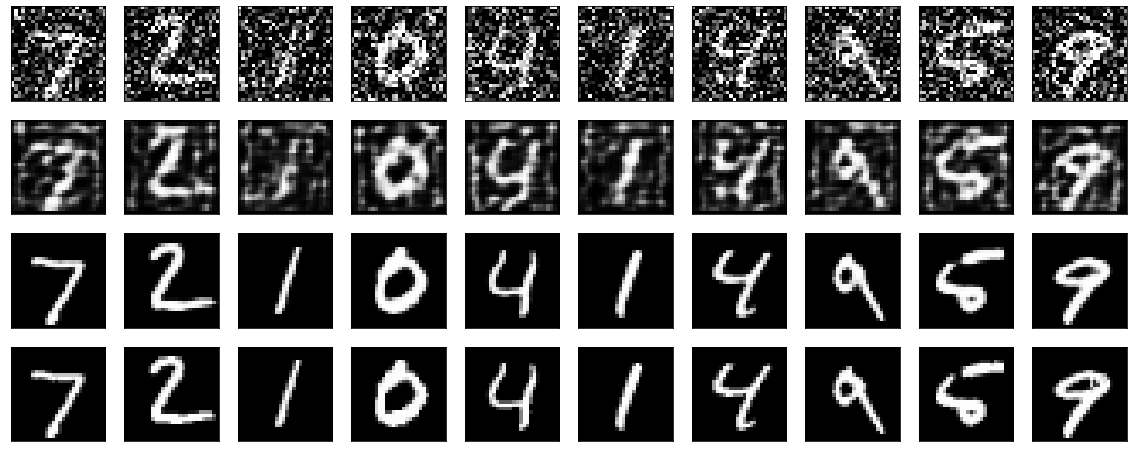


Accuracy of the model (without noise): 0.9896
Accuracy of the model (with noise): 0.6981
Accuracy of the model after 1-iteration 0.8902
Accuracy of the model after 2-iteration 0.8737
Accuracy of the model after 3-iteration 0.8395
Accuracy of the model after 4-iteration 0.8059
Accuracy of the model after 5-iteration 0.7753

Accuracy of the model (without noise): 0.9896
Accuracy of the model (with noise factor = 0.1): 0.989,  after using autoencoder: 0.9889, diff = -9.999999999998899e-05, diff(%): -0.010111223458037309
Accuracy of the model (with noise factor = 0.2): 0.9864,  after using autoencoder: 0.9868, diff = 0.00039999999999995595, diff(%): 0.04055150040551054
Accuracy of the model (with noise factor = 0.30000000000000004): 0.971,  after using autoencoder: 0.9798, diff = 0.00880000000000003, diff(%): 0.906282183316172
Accuracy of the model (with noise factor = 0.4): 0.896,  after using autoencoder: 0.9564, diff = 0.06040000000000001, diff(%): 6.74107142857143
Accuracy of the mode

In [13]:
test_model_autoencoder(model_classifier, model_dcnn_medium, x_test, y_test)

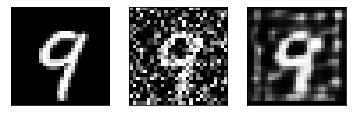

In [14]:
plot_one_img(12, model_dcnn_medium, x_test, noise_factor = 0.5)